In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from matplotlib import rcParams
from highlight_text import ax_text, fig_text, HighlightText
import pandas as pd
import soccerdata as sd
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from adjustText import adjust_text

import warnings
warnings.filterwarnings("ignore")

[01/21/24 21:50:48] INFO     No custom team name replacements found. You can configure these in       ]8;id=496281;file://C:\Users\jawah\anaconda3\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=961558;file://C:\Users\jawah\anaconda3\lib\site-packages\soccerdata\_config.py#85\85]8;;\
                             C:\Users\jawah\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=161995;file://C:\Users\jawah\anaconda3\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=251449;file://C:\Users\jawah\anaconda3\lib\site-packages\soccerdata\_config.py#155\155]8;;\
                             C:\Users\jawah\soccerdata\config\league_dict.json.                                    

In [2]:
import asyncio
import json
# from urllib2 import Request, urlopen
import json
import pandas as pd    
import aiohttp

from understat import Understat
import nest_asyncio


nest_asyncio.apply()


async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        data = await understat.get_league_results("epl",2022)
#         print(json.dumps(data))
        df = pd.DataFrame.from_dict(data, orient='columns')
    return df
        
if __name__ == "__main__": 
    loop = asyncio.get_event_loop()
    df = loop.run_until_complete(main())


In [3]:
def retrieve_home_team(h):
    return h['title']

def retrieve_away_team(a):
    return a['title']

def retrieve_xG_h(xG):
    return xG['h']

def retrieve_xG_a(xG):
    return xG['a']

def retrieve_goals_h(goals):
    return goals['h']

def retrieve_goals_a(goals):
    return goals['a']

def result(row):
    if(row['goals_home'] > row['goals_away']):
        return row['home']
    if(row['goals_home'] < row['goals_away']):
        return row['away']
    else:
        return "Draw"

In [4]:
df['home'] = df['h'].apply(retrieve_home_team)

df['away'] = df['a'].apply(retrieve_away_team)

df['xG_home'] = df['xG'].apply(retrieve_xG_h)

df['xG_away'] = df['xG'].apply(retrieve_xG_a)

df['goals_home'] = df['goals'].apply(retrieve_goals_h)

df['goals_away'] = df['goals'].apply(retrieve_goals_a)

df[['xG_home','xG_away', 'goals_home', 'goals_away']] = df[['xG_home','xG_away', 'goals_home', 'goals_away']].astype(float)

df['Result'] = df.apply (lambda row: result(row), axis=1)

In [5]:
df = df.drop(['h', 'a','goals','xG', 'forecast'], axis =1)

In [7]:
clubs = list(df['home'].unique())


In [10]:
def gen_club_stats(df, club_name):
    club_results = df[(df['home'] == club_name) | (df['away'] == club_name)]
    x_param = []
    y_param = []
    result =[]
    for index, row in club_results.iterrows():
        if row['home'] == club_name:
            x_param.append(row['xG_home'])
            y_param.append(row['xG_away'])
        else:
            x_param.append(row['xG_away'])
            y_param.append(row['xG_home'])
        if row['Result'] == club_name:
            result.append('Win')
        elif row['Result'] == 'Draw':
            result.append('Draw')
        else:
            result.append('Loss')

    club_results = pd.DataFrame(
        {'xG': x_param,
         'xA': y_param,
         'result': result
        })
    return club_results

club_stats = gen_club_stats(df, 'Arsenal')

xg_median = df['xG_home'].median()

In [11]:
def plot_scatter(ax, fig, df, club_name):
    club_stats = gen_club_stats(df, club_name)
    x_param = club_stats['xG']
    y_param = club_stats['xA']
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    colors = {'Loss':'tab:red', 'Draw':'tab:blue', 'Win':'tab:green'}
    ax.scatter(
        x_param, 
        y_param, 
        s = 100 * club_stats['xG'], 
        alpha = 0.6, 
    #     color = "#264653",
        zorder = 3, 
        c=club_stats['result'].map(colors),
        edgecolor="black",
    )

    ax.grid(True, ls = ":", color = "#9b27a8")

#     ax.set_xlabel("xG", x=1 )
#     ax.set_ylabel("xA", y=1, rotation=0, labelpad=20)

    ax.spines.left.set_position('center')
    ax.spines.bottom.set_position('center')
    plt.gca().invert_yaxis()
    
    ax.set_facecolor('#e8f7ab')
    ax.title.set_text(club_name)
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.tick_params(labelbottom=True)
    ax.tick_params(labelleft=True)

    plt.tight_layout()
    return ax


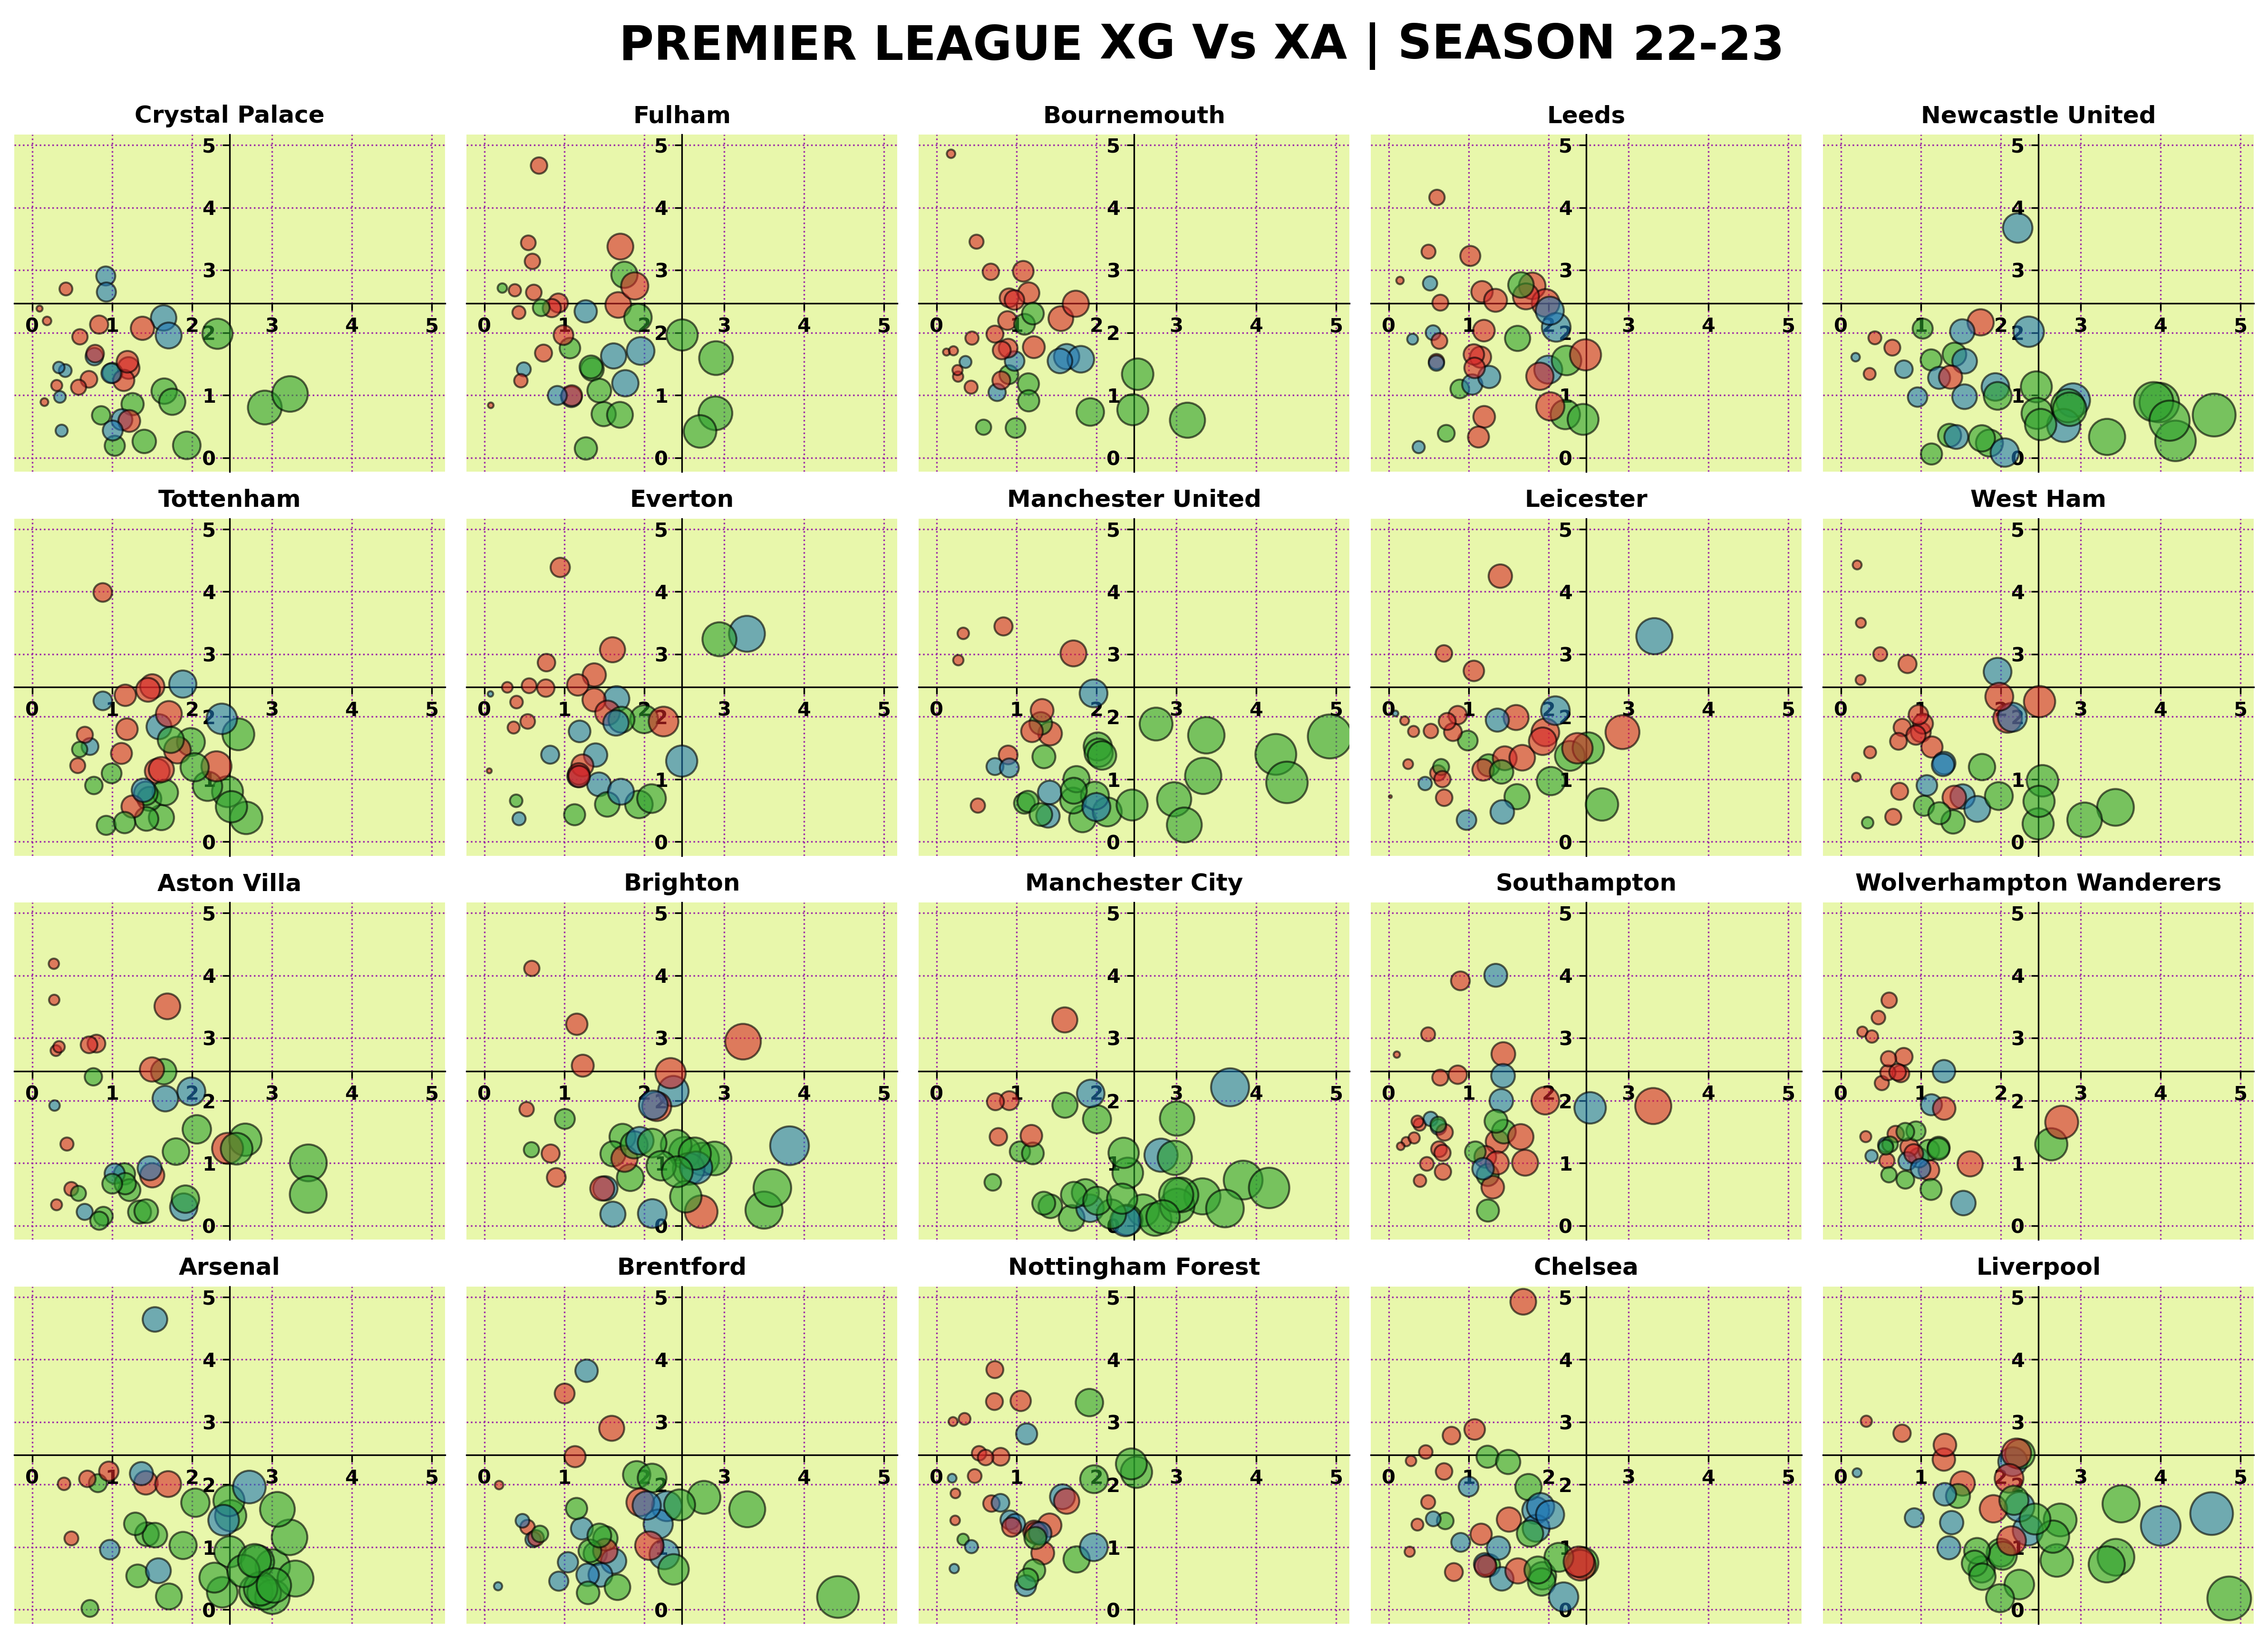

In [14]:
layout_ = '''
    ABCDE
    FGHIJ
    KLMNO
    PQRST
'''

# layout_ = '''
#     ABCD
#     .FG.
#     IJKL
#     .NO.
#     EQRH
#     .MP.
# '''

height_ratios = [1]*4

fig = plt.figure(figsize=(16,12), dpi=300)
axs = fig.subplot_mosaic(
    layout_, 
    sharex=True,sharey=True,
    gridspec_kw={
        'height_ratios':height_ratios,
    }
)

counter = 0

    
for k, ax in axs.items():
    plot_scatter(ax, fig, df, clubs[counter])
    counter += 1

plt.subplots_adjust(bottom = 0.1)



HighlightText(x=-8, y=25,
              fontsize=24,
              ha='center', va='center',
              s='<PREMIER LEAGUE> XG Vs XA | SEASON <22-23>',
#               highlight_textprops=highlight_textprops,
              )

# HighlightText(x=-9, y= 22,
#               fontsize=18,
#               ha='center', va='center',
#               s='<WIN> <DRAW> <LOSE>',
# #               highlight_textprops=subtitle_props,
#               fontname='Roboto'
#               )


plt.savefig(
	"Viz/xGvsxA.png",
	dpi = 300,
	facecolor = "#f1fcc5",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)